In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
# CONSTANTS

#SONG_ID = 8
SR = 44100
FRAME_SIZE = 1024
HOP_SIZE = 512

SONG_LOCATION = "query/countryroads.mp3"

In [ ]:

def load_song(song_location):
    y, sr = librosa.load(song_location, sr=SR)  

    print(f"Shape: {y.shape}, Sample Rate: {SR}")

    time = np.linspace(0, len(y)/sr, len(y)) # start, stop, no of points
    # plt.figure(figsize=(12, 4))
    # plt.plot(time, y, color='blue')
    # plt.show()

    return spectro(y)

In [ ]:
def spectro(y):
    D = librosa.stft(y, n_fft = 2048, hop_length=HOP_SIZE)

    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # plt.figure(figsize=(12, 6))
    # librosa.display.specshow(S_db, sr=SR, hop_length=512,
    #                         x_axis='time', y_axis='hz', cmap='magma')
    # plt.colorbar(format="%+2.0f dB")
    # plt.title("Spectrogram (dB)")
    # plt.show()

    return find_peaks(S_db, y)

In [5]:
from scipy.ndimage import maximum_filter, generate_binary_structure, iterate_structure

def find_peaks(spec_db, y):

    from scipy.ndimage import maximum_filter
    neighborhood_size = (30, 30)
    local_max = maximum_filter(spec_db, size=neighborhood_size) == spec_db
    peaks = np.argwhere(local_max)

    # filtering out the low frequencies
    peaks = [(t, f) for f, t in peaks if spec_db[f, t] > -40]  # -40 dB threshold

    peak_points = []
    for (t, f) in peaks:
        time = t * HOP_SIZE / SR
        freq = f * SR / FRAME_SIZE
        peak_points.append((time, freq))

    # plot peaks
    plt.figure(figsize=(12, 6))

    # Plot spectrogram
    plt.imshow(spec_db, origin="lower", aspect="auto", cmap="magma",
            extent=[0, len(y)/SR, 0, SR/2])

    # Overlay peaks
    times = [p[0] for p in peak_points]
    freqs = [p[1] for p in peak_points]
    plt.scatter(times, freqs, color="cyan", marker=".", s=10, label="Peaks")

    plt.colorbar(label="Magnitude (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectrogram with Detected Peaks")
    plt.legend(loc="upper right")
    plt.show()

    return peak_points



In [6]:
def encodehash(f_a, f_b, delta_t):
    f_a = int(f_a)
    f_b = int(f_b)
    delta_t = int(delta_t)
    hash_val = (f_a << (10 + 9)) | (f_b << 9) | delta_t

    hash_val &= 0xFFFFFFFF

    return hash_val
    #return (int(f1) << 20) | (int(f2) << 8) | int(delta_t)

def decodehash(hash_val):
    delta_t = hash_val & ((1 << 9) - 1)
    f_b = (hash_val >> 9) & ((1 << 10) - 1)
    f_a = (hash_val >> 19) & ((1 << 10) - 1)

    return (f_a, f_b, delta_t)

In [7]:
MIN_TIME_DELTA = 0.5  # Minimum time offset in seconds
MAX_TIME_DELTA = 1  # Maximum time offset in seconds
MAX_FREQ_DELTA = 300
FAN_OUT = 5

def create_hashes(peaks, SONG_ID):
    hashes = {}

    total_peaks = len(peaks)
    for i in range(total_peaks):
        f_a, t_a_frame = peaks[i]

        # reset counter for each new anchor peak
        pairs_formed = 0

        for j in range(i + 1, total_peaks):
            f_b, t_b_frame = peaks[j]

            # --- THE FIX ---
            # Convert frame indices to seconds
            t_a_sec = t_a_frame * HOP_SIZE / SR
            t_b_sec = t_b_frame * HOP_SIZE / SR
            delta_t = t_b_sec - t_a_sec
            # --- END FIX ---
            delta_f = f_b - f_a
            # print(f_a, f_b, delta_t)

            

            if MIN_TIME_DELTA <= delta_t <= MAX_TIME_DELTA and delta_f <= MAX_FREQ_DELTA:
                scaled_delta_t = int(delta_t * 100) 
                hash_val = encodehash(f_a, f_b, scaled_delta_t)

                if hash_val not in hashes:
                    hashes[hash_val] = []
                hashes[hash_val].append((SONG_ID, t_a_sec))

                pairs_formed += 1
                
                if pairs_formed >= FAN_OUT:
                    break

            # Since the peaks are sorted by time, if you've passed the max
            # delta, you can break the inner loop and move to the next anchor.
            elif delta_t > MAX_TIME_DELTA:
                break

    print(f"Found {len(peaks)} peaks")
    print(f"Generated {len(hashes)} unique hashes")
    print(f"Total stored hashes (including duplicates): {sum(len(v) for v in hashes.values())}")

    return hashes

In [8]:
# Saving to local database using pickle for now
# We can move onto using a better database like redis later
import pickle
DB_FILENAME = "fingerprints.pkl"

def save_hashes(hashes):
    with open(DB_FILENAME, 'ab') as f:  
        pickle.dump(hashes, f)
    print(f"Successfully appended {len(hashes)} fingerprints to {DB_FILENAME}")

def load_hashes():
    with open(DB_FILENAME, 'rb') as f:
        loaded_hashes = pickle.load(f)
    
    return loaded_hashes

In [9]:
import collections
import pickle

def load_hashes():
    """Loads the fingerprint database from a pickle file."""
    with open('fingerprints.pkl', 'rb') as f:
        return pickle.load(f)

# 'hashes' is the variable you generated from fingerprinting your query song.
# Its structure is {hash: [(song_id, time), ...]}
# Example: {4723200: [(4, np.float64(2.5))]}

def match_hashes(hashes):
    # 1. Load the database of saved song fingerprints
    saved_hashes = load_hashes()

    # 2. Run the matching algorithm directly on the query's hashes
    histogram = collections.defaultdict(int)

    # --- This is the simplified and corrected loop ---
    for hash_val, query_data in hashes.items():
        # Check if the hash from our query exists in the database
        if hash_val in saved_hashes:
            # Get the time of the query's hash
            # query_data is a list like [(4, 2.5)], so we get the first item's time
            t_query = query_data[0][1]

            # A single hash can match multiple times in the database (rare)
            for song_id, t_database in saved_hashes[hash_val]:
                offset = t_database - t_query
                
                # Use the (song_id, time_offset) as the key for our histogram
                key = (int(song_id), int(round(offset))) # Round offset to nearest int
                histogram[key] += 1

    # 3. Find the song with the most matching offsets
    if not histogram:
        print("No matches found.")
    else:
        # Find the (song_id, offset) pair with the highest vote count
        best_match = max(histogram.items(), key=lambda item: item[1])
        
        (song_id, offset), num_votes = best_match

        print("--- Match Found! ---")
        print(f"Best Match: Song ID {song_id}")
        print(f"Confidence (votes): {num_votes}")

        # Optional: You can add your debugging block here if needed
        print("\n--- Debug Info ---")
        query_hashes_set = set(hashes.keys())
        db_hashes_set = set(saved_hashes.keys())
        common_hashes = query_hashes_set.intersection(db_hashes_set)
        print(f"Total Hashes in Query: {len(query_hashes_set)}")
        print(f"Total Hashes in Database: {len(db_hashes_set)}")
        print(f"Number of Common Hashes Found: {len(common_hashes)}")

In [10]:
def save_db(SONG_LOCATION, SONG_ID):
    peaks = load_song(SONG_LOCATION)
    hashes = create_hashes(peaks, SONG_ID)
    save_hashes(hashes)

songs = ["songs/Hangman.mp3", "songs/The Moon.mp3", "songs/02. Eleanor Rigby.mp3"]

for i in range(len(songs)):
    pass
    # save_db(songs[i], i)


In [11]:
# for query
#match_hashes(hashes)

def find_match(SONG_LOCATION, SONG_ID):
    peaks = load_song(SONG_LOCATION)
    hashes = create_hashes(peaks, SONG_ID)

    match_hashes(hashes)

# find_match("query/countryroads.mp3", 6)


In [12]:
import librosa
import numpy as np
import pickle
import collections
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure

def save_db():
    """Builds and saves the fingerprint database."""
    songs = [
        ("songs/Hangman.mp3", 0),
        ("songs/The Moon.mp3", 1),
        ("songs/02. Eleanor Rigby.mp3", 2)
    ]
    
    db = collections.defaultdict(list)
    for location, song_id in songs:
        print(f"Fingerprinting '{location}' with SONG_ID = {song_id}")
        peaks = load_song(location)
        hashes = create_hashes(peaks, song_id)
        for hash_val, hash_info in hashes.items():
            db[hash_val].extend(hash_info)
            
    with open('fingerprints.pkl', 'wb') as f:
        pickle.dump(db, f)
    print("Database saved successfully.")

# NEW HELPER FUNCTION FOR THE QUERY
def fingerprint_query(song_location):
    """
    Fingerprints a query song. 
    Crucially, it does NOT assign a SONG_ID. 
    It returns a simple dictionary of {hash: time}.
    """
    # Use your existing fingerprint function, but with a placeholder ID
    peaks = load_song(song_location) 

    hashes_with_id = create_hashes(peaks, SONG_ID=-1) # -1 is a dummy ID
    
    # Convert to the {hash: time} format needed for matching
    query_hashes = {}
    for hash_val, hash_info in hashes_with_id.items():
        if hash_info:
            query_hashes[hash_val] = hash_info[0][1] # Get the time
            
    return query_hashes

# THE CORRECTED MATCHING FUNCTION
def find_match(song_location):
    """Finds the best match for a query song against the database."""
    
    # 1. Load the database
    with open('fingerprints.pkl', 'rb') as f:
        saved_hashes = pickle.load(f)
        
    # 2. Fingerprint the query song (without assigning a real ID)
    query_hashes = fingerprint_query(song_location)
    
    # 3. Run the matching algorithm
    histogram = collections.defaultdict(int)
    
    for query_hash, t_query in query_hashes.items():
        if query_hash in saved_hashes:
            for db_song_id, t_database in saved_hashes[query_hash]:
                offset = t_database - t_query
                key = (int(db_song_id), int(round(offset)))
                histogram[key] += 1
                
    # 4. Find the winning song
    if not histogram:
        print("No matches found.")
        return None
    
    best_match = max(histogram.items(), key=lambda item: item[1])
    (song_id, offset), num_votes = best_match
    
    print("--- Match Found! ---")
    print(f"Best Match: Song ID {song_id}")
    print(f"Confidence (votes): {num_votes}")
    
    # --- Debug Info ---
    query_set = set(query_hashes.keys())
    db_set = set(saved_hashes.keys())
    common_hashes = query_set.intersection(db_set)
    print(f"Total Hashes in Query: {len(query_set)}")
    print(f"Number of Common Hashes Found: {len(common_hashes)}")

    return song_id 

Fingerprinting 'songs/Hangman.mp3' with SONG_ID = 0


[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Shape: (8649728,), Sample Rate: 44100


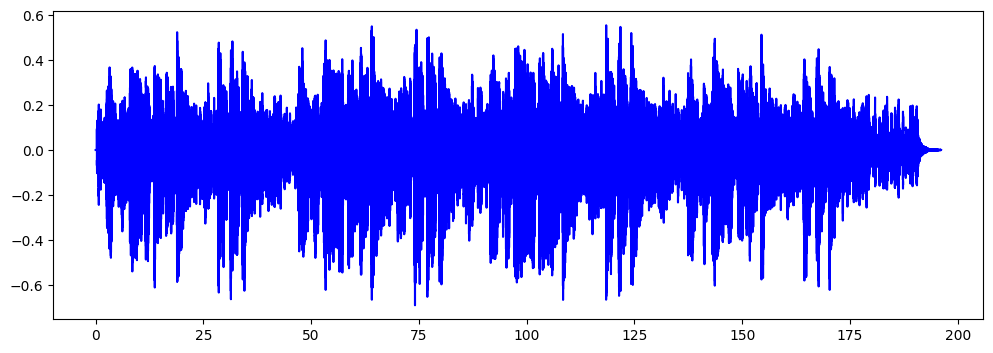

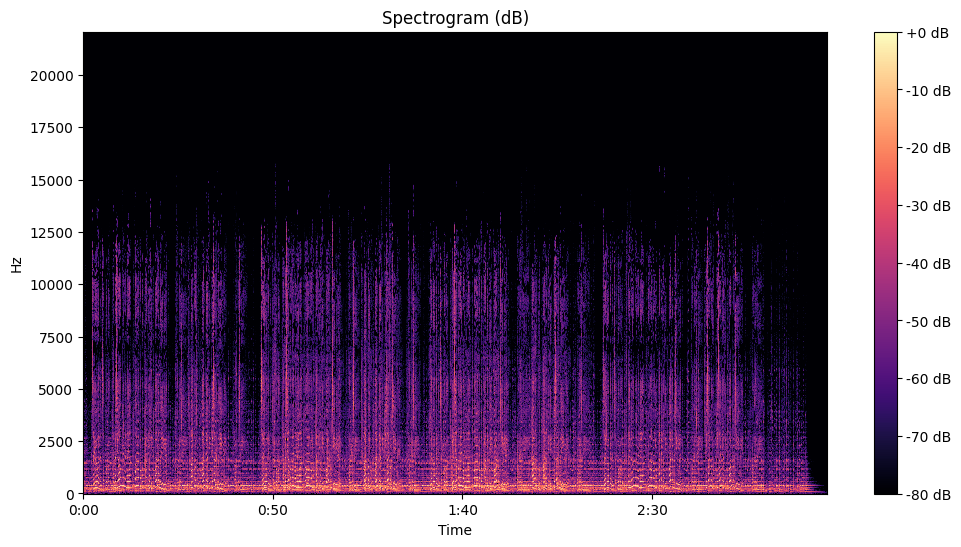

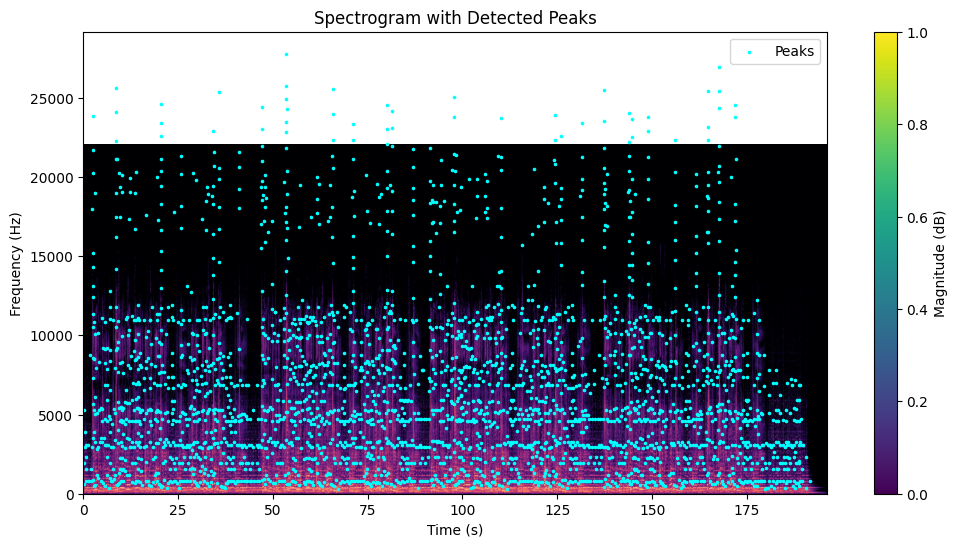

Found 2974 peaks
Generated 9897 unique hashes
Total stored hashes (including duplicates): 12975
Fingerprinting 'songs/The Moon.mp3' with SONG_ID = 1
Shape: (13965312,), Sample Rate: 44100


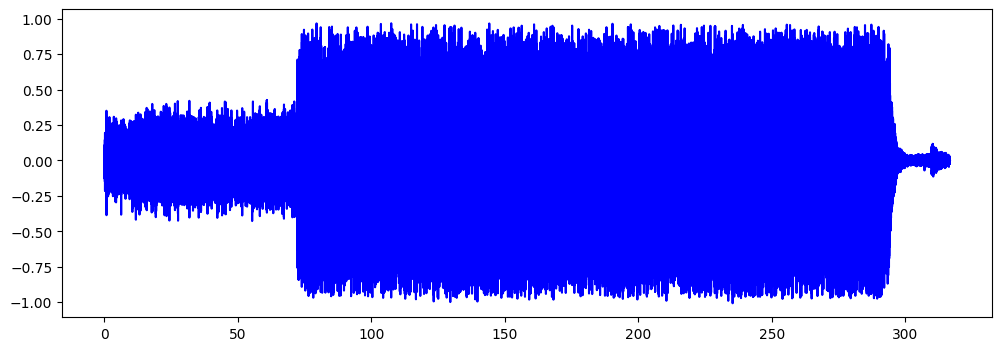

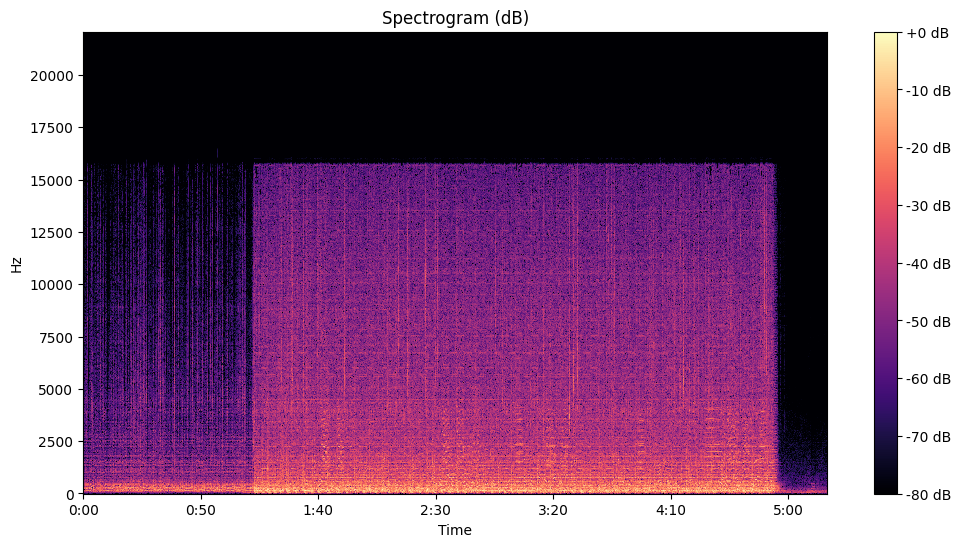

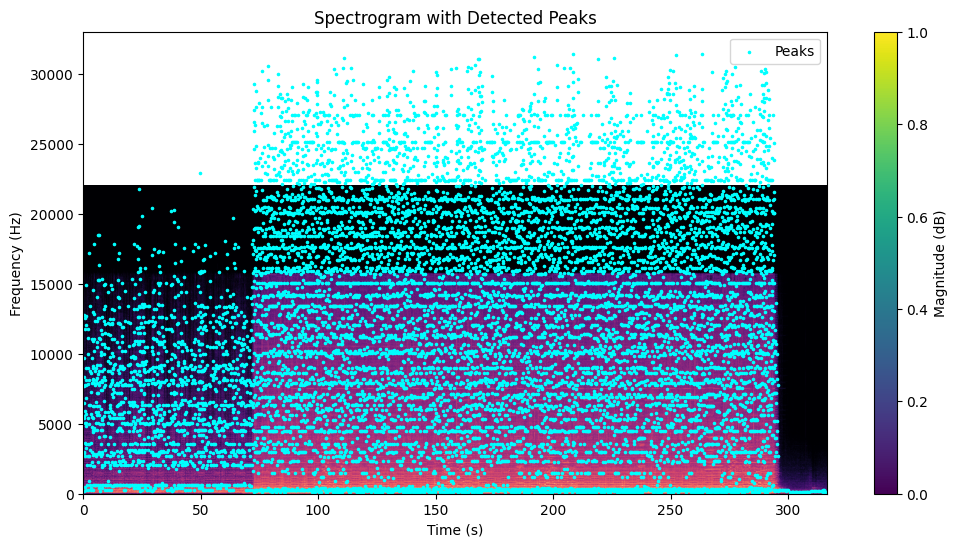

Found 12322 peaks
Generated 32551 unique hashes
Total stored hashes (including duplicates): 61124
Fingerprinting 'songs/02. Eleanor Rigby.mp3' with SONG_ID = 2
Shape: (5574656,), Sample Rate: 44100


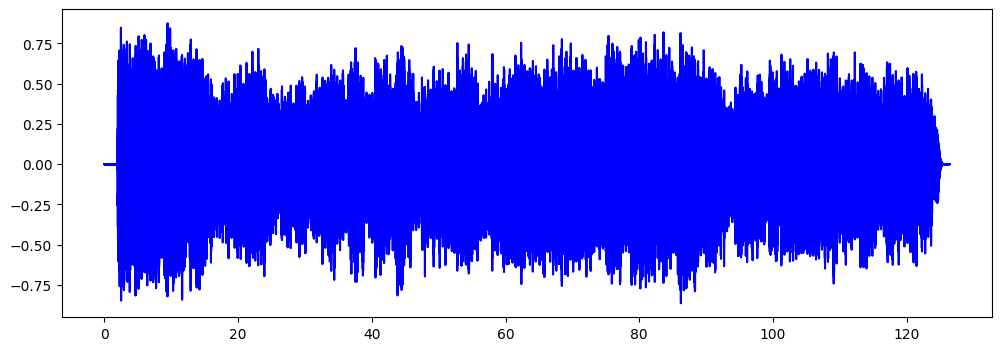

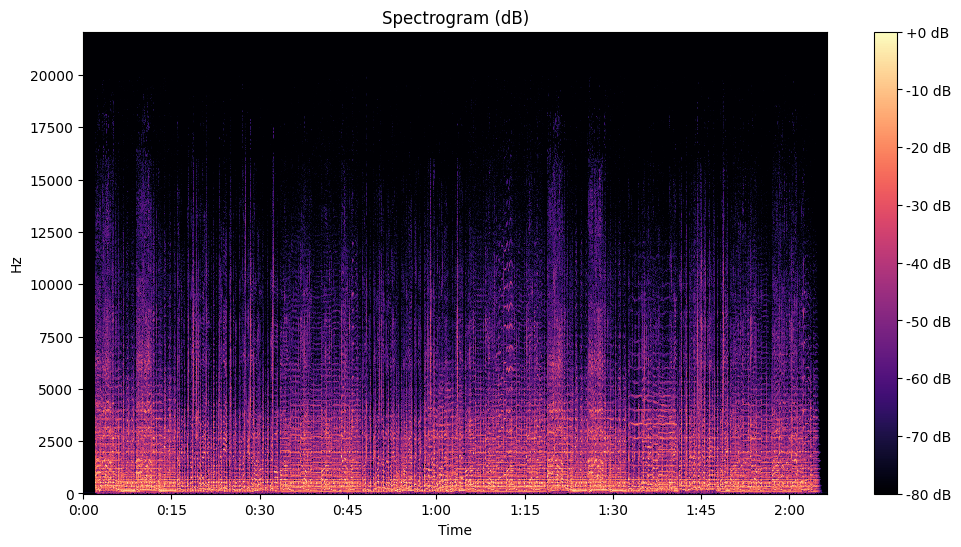

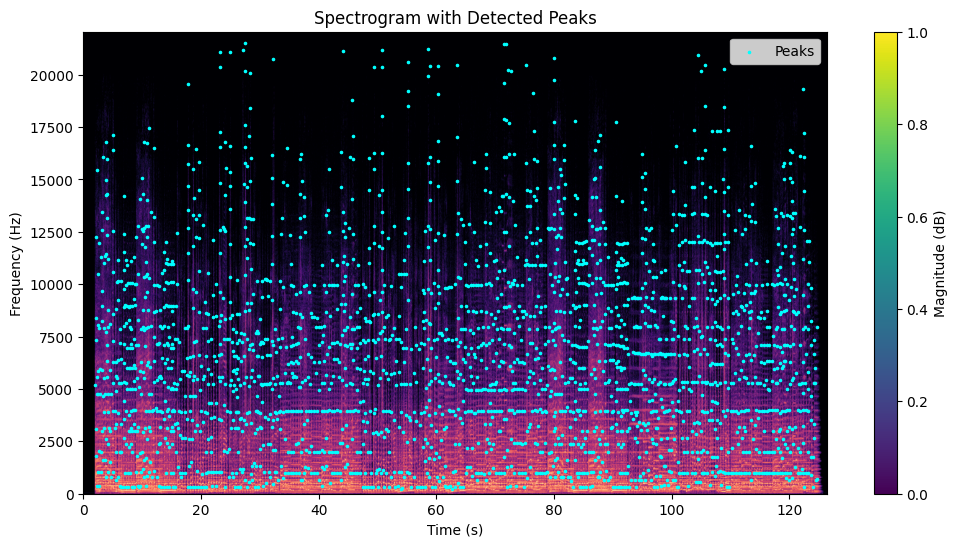

Found 2759 peaks
Generated 7196 unique hashes
Total stored hashes (including duplicates): 12851
Database saved successfully.


In [13]:
save_db()

In [14]:
#find_match("query/rigby_original.mp3")

Note: Illegal Audio-MPEG-Header 0x2c302c39 at offset 1203840.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/wp/vt3nky3n4yj60swtpg7yz1500000gn/T/ipykernel_43583/4151169582.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(song_location, sr=SR)
/Users/anantagarwal/Desktop/dev/projects/shazam/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Shape: (1327234,), Sample Rate: 44100


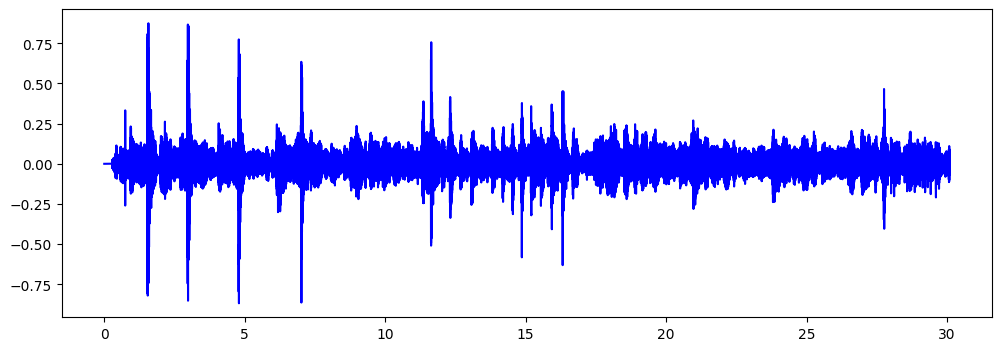

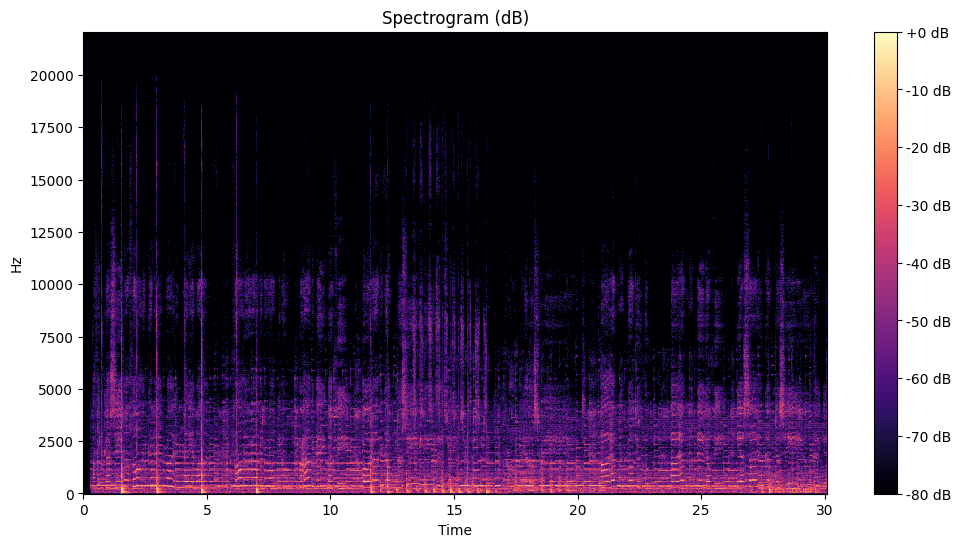

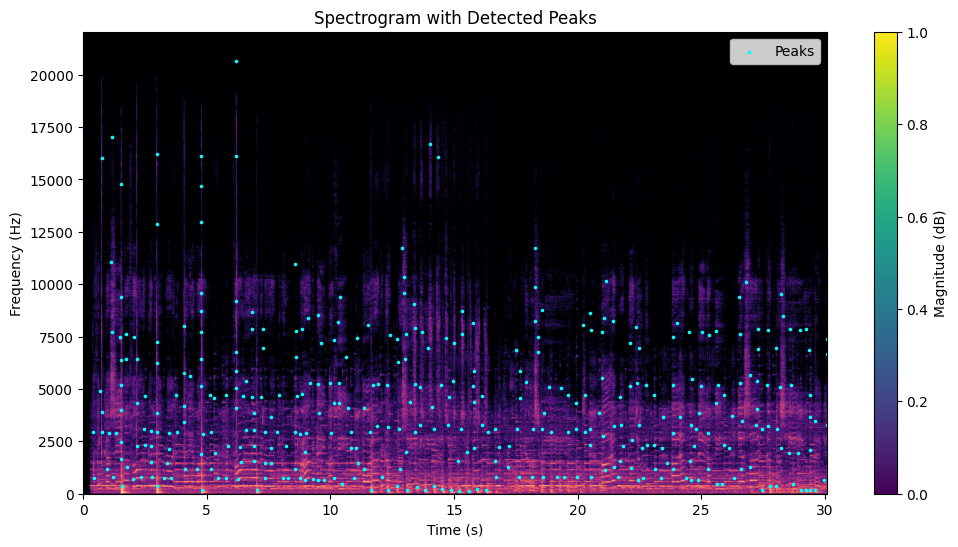

Found 373 peaks
Generated 629 unique hashes
Total stored hashes (including duplicates): 927
--- Match Found! ---
Best Match: Song ID 2
Confidence (votes): 51
Total Hashes in Query: 629
Number of Common Hashes Found: 447


2

In [15]:
find_match("query/hangman.mp3")

Shape: (1345227,), Sample Rate: 44100


Note: Illegal Audio-MPEG-Header 0x2c302c33 at offset 1220160.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/wp/vt3nky3n4yj60swtpg7yz1500000gn/T/ipykernel_43583/4151169582.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(song_location, sr=SR)


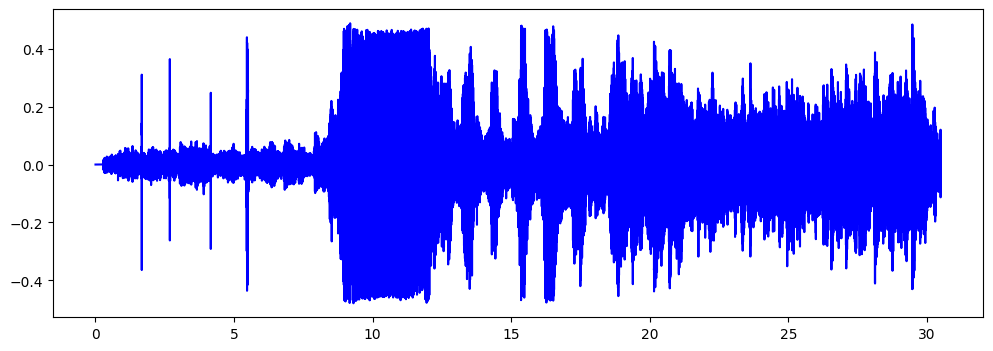

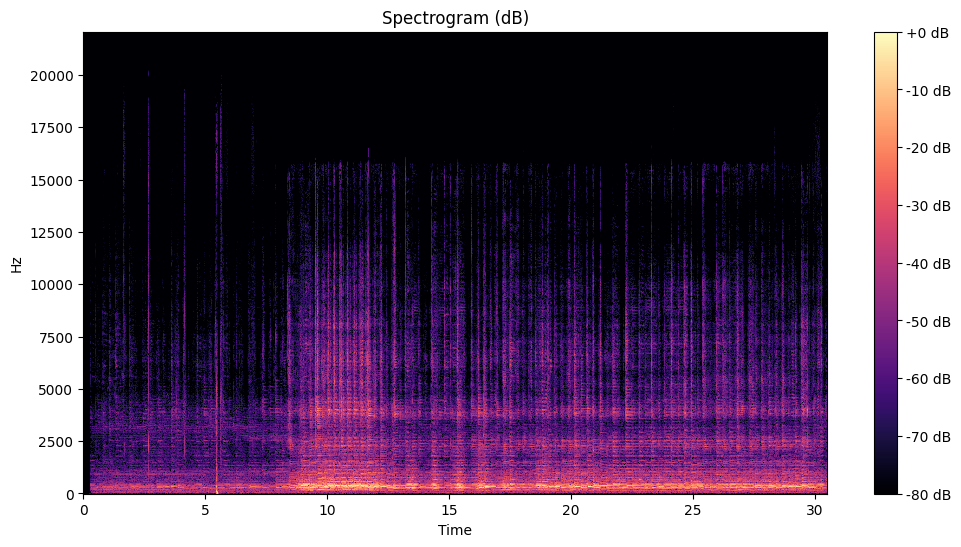

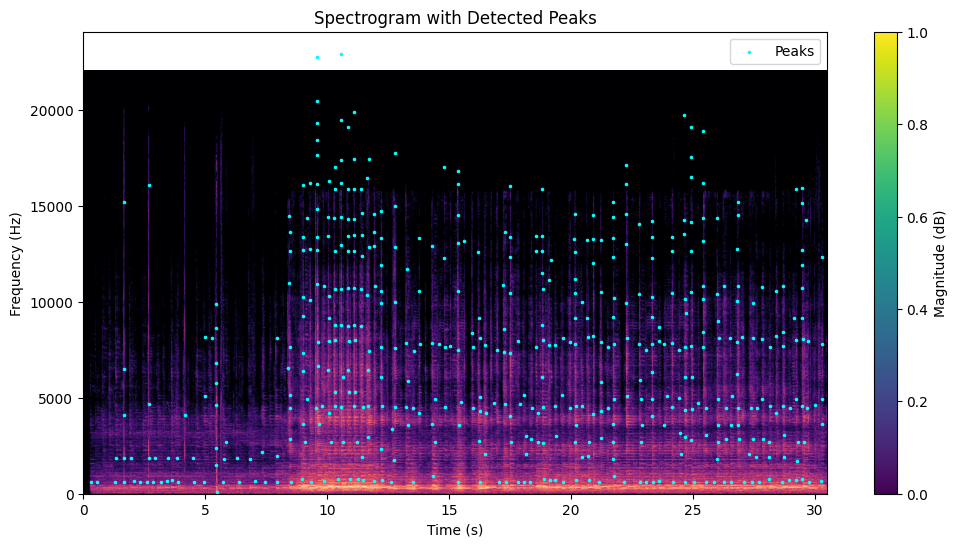

Found 500 peaks
Generated 748 unique hashes
Total stored hashes (including duplicates): 1465
--- Match Found! ---
Best Match: Song ID 2
Confidence (votes): 92
Total Hashes in Query: 748
Number of Common Hashes Found: 564


2

In [16]:
find_match("query/moon.mp3")

Shape: (7947526,), Sample Rate: 44100


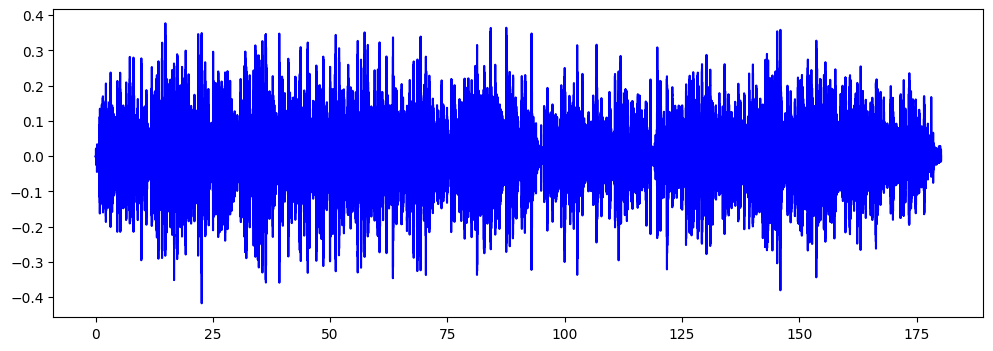

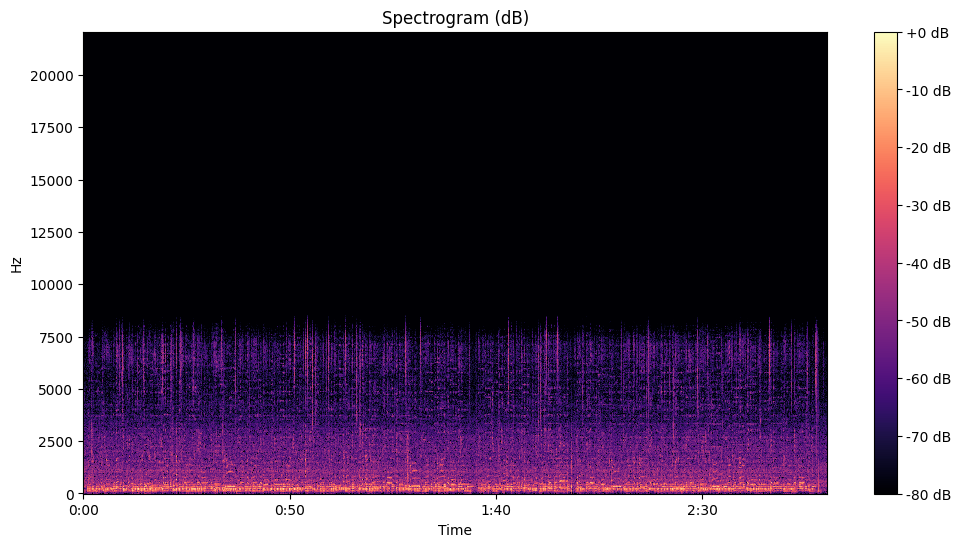

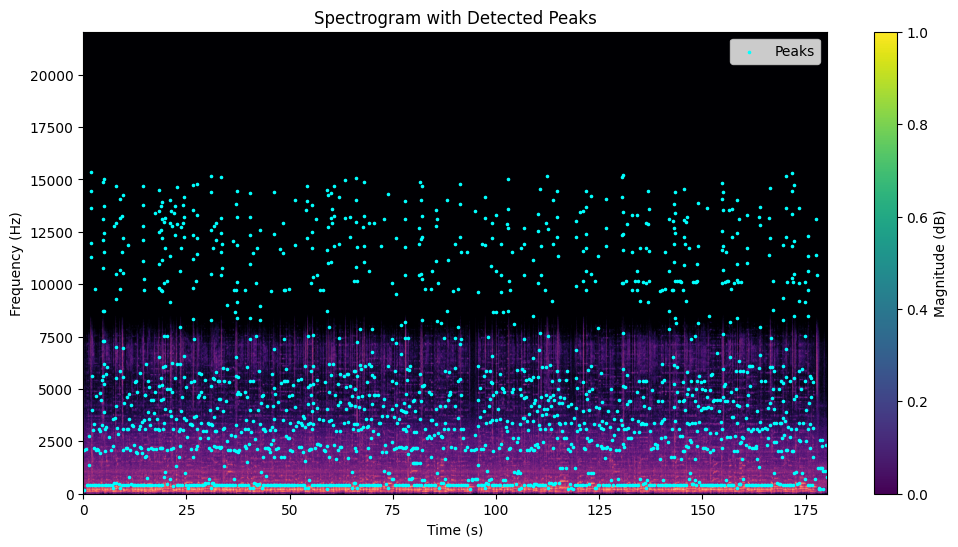

Found 1858 peaks
Generated 6232 unique hashes
Total stored hashes (including duplicates): 8222
--- Match Found! ---
Best Match: Song ID 2
Confidence (votes): 318
Total Hashes in Query: 6232
Number of Common Hashes Found: 3891


2

In [17]:
find_match("query/countryroads.mp3")